# Финальный проект

<br> <span>
# Промышленность
</br>

<img src=https://cityreporter.ru/wp-content/uploads/2017/02/BrammenstranggussanlageHKM_57789.jpg width="400">

**Цель работы:** Нужно построить модель, которая предскажет температуру стали.

**Цель применния**: Для оптимизации производственных расходов, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали  

**Исходные данные**: Данные состоят из файлов, полученных из разных источников:
* data_arc.csv — данные об электродах;
* data_bulk.csv — данные о подаче сыпучих материалов (объём);
* data_bulk_time.csv — данные о подаче сыпучих материалов (время);
* data_gas.csv — данные о продувке сплава газом;
* data_temp.csv — результаты измерения температуры;
* data_wire.csv — данные о проволочных материалах (объём);
* data_wire_time.csv — данные о проволочных материалах (время).  

**Дополнительная информация**:   
#### Описание этапа обработки  


Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша.Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

## План работы
* Загрузить данные и провести исследовательский анализ
* Сформировать результирующий набор данных
* Обучить  модель регрессии. По рез-ту важности признаков вернутся к редактированию рез-го набора данных
* Вывод
* Составить отчёт о проделанной работе

## Загружаем библиотеки 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor

pd.set_option('display.max_columns', None) #для полного отображения колонок
pd.set_option('display.max_rows', None) #для полного отображения строк

import warnings # игнорирование предупреждений
warnings.filterwarnings('ignore')

## Загружаем данные 

In [2]:
data_arc = pd.read_csv('data_arc.csv')
data_bulk = pd.read_csv('data_bulk.csv')
data_bulk_time = pd.read_csv('data_bulk_time.csv')
data_gas = pd.read_csv('data_gas.csv')
data_temp = pd.read_csv('data_temp.csv')
data_wire = pd.read_csv('data_wire.csv')
data_wire_time = pd.read_csv('data_wire_time.csv')

### Данные об электродах:

In [3]:
print(data_arc.info())
print()
data_arc.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
key                     14876 non-null int64
Начало нагрева дугой    14876 non-null object
Конец нагрева дугой     14876 non-null object
Активная мощность       14876 non-null float64
Реактивная мощность     14876 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
None



,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


#### Первичный вывод:
* Необходимо добавить столбец **"Продолжительность нагрева дугой"**
* Пропуски отсутствуют
* Необходимо привести формат даты к формату Datetime

#### Приведение к формату Datetime

In [4]:
data_arc['Начало нагрева дугой']=pd.to_datetime(data_arc['Начало нагрева дугой'])
data_arc['Конец нагрева дугой']=pd.to_datetime(data_arc['Конец нагрева дугой'])

 #### Добавление столбца "Продолжительность нагрева дугой"

In [5]:
data_arc['Продолжительность нагрева дугой'] = (data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой'])

#### Выведем статистические данные для данного набора

In [6]:
data_arc.describe()

,key,Активная мощность,Реактивная мощность,Продолжительность нагрева дугой
count,14876.000000,14876.000000,14876.000000,14876
mean,1615.220422,0.670441,0.452592,0 days 00:02:51.670946
std,934.571502,0.408159,5.878702,0 days 00:01:38.186802
min,1.000000,0.030002,-715.504924,0 days 00:00:11
25%,806.000000,0.395297,0.290991,0 days 00:01:47
50%,1617.000000,0.555517,0.415962,0 days 00:02:27
75%,2429.000000,0.857034,0.637371,0 days 00:03:34
max,3241.000000,3.731596,2.676388,0 days 00:15:07


Стоит обратить внимание на минимальное значение столбца "Реактивная мощность"

In [7]:
data_arc[data_arc['Реактивная мощность']<=0]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Продолжительность нагрева дугой
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924,00:01:49


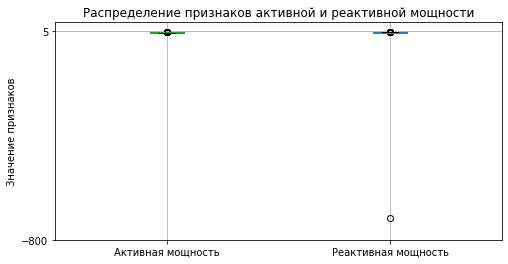

In [8]:
plt.figure(figsize=(8,4))
data_arc.boxplot(['Активная мощность','Реактивная мощность'])
plt.title('Распределение признаков активной и реактивной мощности')
plt.yticks([-800, 5])
plt.ylabel('Значение признаков')
plt.show()

Удалим  этот явный выброс

In [9]:
data_arc = data_arc.drop(index=[9780]).reset_index(drop=True)

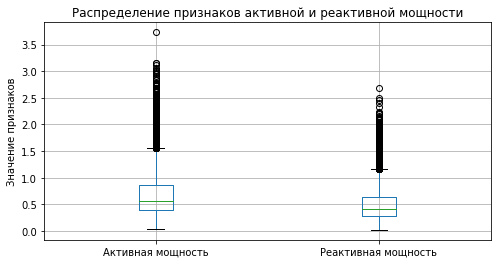

In [10]:
plt.figure(figsize=(8,4))
data_arc.boxplot(['Активная мощность','Реактивная мощность'])
plt.title('Распределение признаков активной и реактивной мощности')
plt.ylabel('Значение признаков')
plt.show()

#### Корреляция между признаками в данном наборе

In [11]:
data_arc.corr()

,key,Активная мощность,Реактивная мощность
key,1.000000,-0.021367,-0.000159
Активная мощность,-0.021367,1.000000,0.963182
Реактивная мощность,-0.000159,0.963182,1.000000


Высокая корреляция между активной и реактивной мощностями, явное проявление мультиколлинеарности

>Это означает, что конкретные результаты оценки могут сильно различаться для разных выборок несмотря на то, что выборки однородны

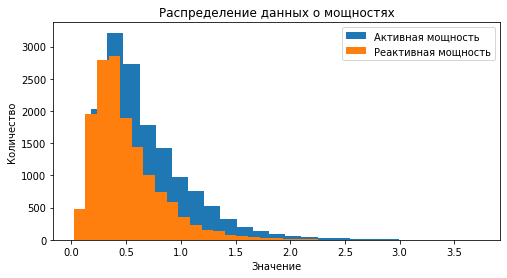

In [12]:
plt.figure(figsize=(8,4))
data_arc['Активная мощность'].plot(kind='hist', bins=25, legend=True)
data_arc['Реактивная мощность'].plot(kind='hist', bins=25, legend=True)
plt.title('Распределение данных о мощностях')
plt.xlabel('Значение')
plt.ylabel('Количество')
plt.show()

Введем новый признак "Полная мощность"

In [13]:
data_arc['Полная мощность'] = np.sqrt(data_arc['Активная мощность'] ** 2 + data_arc['Реактивная мощность'] ** 2)

#### Промежуточный итог по файлу об электродах

In [14]:
print(data_arc.info())
print()
print(data_arc.describe())
print()
data_arc.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14875 entries, 0 to 14874
Data columns (total 7 columns):
key                                14875 non-null int64
Начало нагрева дугой               14875 non-null datetime64[ns]
Конец нагрева дугой                14875 non-null datetime64[ns]
Активная мощность                  14875 non-null float64
Реактивная мощность                14875 non-null float64
Продолжительность нагрева дугой    14875 non-null timedelta64[ns]
Полная мощность                    14875 non-null float64
dtypes: datetime64[ns](2), float64(3), int64(1), timedelta64[ns](1)
memory usage: 813.6 KB
None

                key  Активная мощность  Реактивная мощность  \
count  14875.000000       14875.000000         14875.000000   
mean    1615.186756           0.670453             0.500723   
std      934.593897           0.408170             0.310880   
min        1.000000           0.030002             0.020806   
25%      806.000000           0.395295             0.2

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Продолжительность нагрева дугой,Полная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,00:03:48,1.193639
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,00:03:05,0.959010
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,00:02:52,0.896038
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,00:06:05,1.970470
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,00:02:28,0.807239


#### Вывод:
* Добавили признак **"Продолжительность нагрева дугой"**
* Привели формат даты к формату Datetime
* Удалили 1 явный выброс
* Выявили сильную корреляцию между мощностями.Добавили новый признак **"Полная мощность"**
    

### Данные о подаче сыпучих материалов (объём)

In [15]:
print(data_bulk.info())
print()
print(data_bulk.describe())
print()
data_bulk.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB
None

               key      Bulk 1      Bulk 2       Bulk 3       Bulk 4  \
count  3129.000000  252.000000   22.000000  1298.000000  1014.000000   
mean  

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


#### Первичный вывод:
* Наличие пропусков. Заменим пропуски 0. Примем для себя следюущее: NaN - отсуствие добавление элемента.
* Неизвестная мера измерения. Было бы отлично уточнить, в чем измеряется каждый материал.
* Совпаденим минимального и максимального key с предыдущим набором данных( data_arc)

#### Замена пропусков

In [16]:
def fillna_zero(df):
    for i in df.columns.drop('key'):
        df[i] = df[i].fillna(0)
    return df

#применение функции
fillna_zero(data_bulk)
data_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


#### Корреляция между признаками в данном наборе

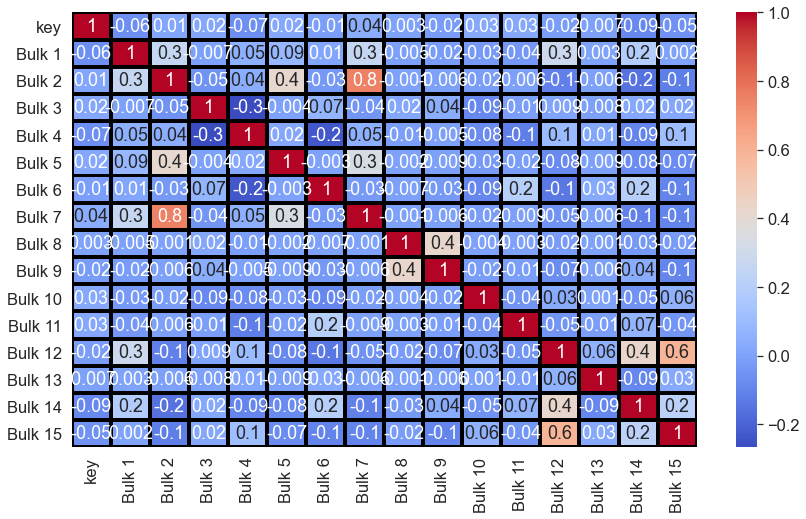

In [17]:
corr = data_bulk.corr()
plt.figure(figsize= (14,8)) 
sns.set(font_scale=1.5) 
sns.heatmap(corr, annot=True,fmt='.1g',cmap= 'coolwarm', linewidths=3, linecolor='black')
plt.show()

Есть  хорошая корреляция между определенными признаками, но на данном этапе не придадим этому значение.

### Данные о подаче сыпучих материалов (время)

In [18]:
print(data_bulk_time.info())
print()
print(data_bulk_time.describe())
print()
data_bulk_time.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB
None

               key
count  3129.000000
mean   1624.383509
std     933.337642
min       1.000000
25%     816.000000
50%    1622.000000
75%    2431.000000
max    3241.0000

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


Сравним с предыдущим набором данных(data_bulk)

In [19]:
display(data_bulk.head())
display(data_bulk_time.head())
print()
display(data_bulk.tail())
display(data_bulk_time.tail())

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
3124,3237,0.0,0.0,170.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,252.0,0.0,130.0,206.0
3125,3238,0.0,0.0,126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,254.0,0.0,108.0,106.0
3126,3239,0.0,0.0,0.0,0.0,0.0,114.0,0.0,0.0,0.0,0.0,0.0,158.0,0.0,270.0,88.0
3127,3240,0.0,0.0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,192.0,54.0
3128,3241,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,180.0,52.0


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
3124,3237,NaN,NaN,2019-08-31 22:51:28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 22:46:52,NaN,2019-08-31 22:46:52,2019-08-31 22:46:52
3125,3238,NaN,NaN,2019-08-31 23:39:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 23:33:09,NaN,2019-08-31 23:33:09,2019-08-31 23:33:09
3126,3239,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:51:58,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:39:41,NaN,2019-09-01 01:33:25,2019-09-01 01:33:25
3127,3240,NaN,NaN,NaN,NaN,NaN,2019-09-01 03:12:40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-01 02:41:27,2019-09-01 02:41:27
3128,3241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-01 04:05:34,2019-09-01 04:05:34


Сравнивая две таблицы, заметим, что подача материала происходит только тогда, когда есть время замера. Следовательно, замена NaN нулями в data_bulk  правильное решение

### Замена пропусков

In [20]:
def fillna_zero(df):
    for i in df.columns.drop('key'):
        df[i] = df[i].fillna(0)
    return df

#применение функции
fillna_zero(data_bulk_time)
data_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,0,0,0,2019-05-03 11:21:30,0,0,0,0,0,0,0,2019-05-03 11:03:52,0,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,0,0,0,2019-05-03 11:46:38,0,0,0,0,0,0,0,2019-05-03 11:40:20,0,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,0,0,0,2019-05-03 12:31:06,0,0,0,0,0,0,0,2019-05-03 12:09:40,0,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,0,0,0,2019-05-03 12:48:43,0,0,0,0,0,0,0,2019-05-03 12:41:24,0,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,0,0,0,2019-05-03 13:18:50,0,0,0,0,0,0,0,2019-05-03 13:12:56,0,2019-05-03 13:12:56,2019-05-03 13:12:56


### Данные о продувке сплава газом

In [21]:
print(data_gas.info())
print()
print(data_gas.describe())
print()
data_gas.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
None

               key        Газ 1
count  3239.000000  3239.000000
mean   1621.861377    11.002062
std     935.386334     6.220327
min       1.000000     0.008399
25%     812.500000     7.043089
50%    1622.000000     9.836267
75%    2431.500000    13.769915
max    3241.000000    77.995040



,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


#### Корреляция между признаками в данном наборе

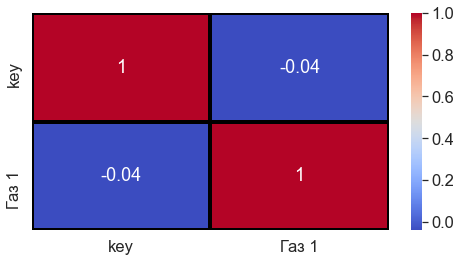

In [22]:
corr = data_gas.corr()
plt.figure(figsize= (8,4))
sns.set(font_scale=1.5) 
sns.heatmap(corr, annot=True,fmt='.1g',cmap= 'coolwarm', linewidths=3, linecolor='black')
plt.show()

Явная корреляция между признаками отсутствует

### Результаты измерения температуры

In [23]:
print(data_temp.info())
print()
print(data_temp.describe())
print()
data_temp.head(6)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB
None

                key   Температура
count  15907.000000  13006.000000
mean    1607.880870   1591.840920
std      942.212073     21.375851
min        1.000000   1191.000000
25%      790.000000   1581.000000
50%     1618.000000   1591.000000
75%     2427.000000   1601.000000
max     3241.000000   1705.000000



,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0


####  Первичный вывод:
* Определили где находится целевой признак
* Совпадение минимального и максимального key с предыдущим наборами данных
* Присутствуют  пропуски в столбце "Температура"
* Необходимо привести формат даты к формату Datetime

#### Приведение к формату Datetime

In [24]:
data_temp['Время замера']=pd.to_datetime(data_temp['Время замера'])

#### Определим начальную и конечную температуру в партии

In [25]:
data_temp_info = (data_temp.pivot_table(index='key', aggfunc=['max','min'])).reset_index()
data_temp_info.columns=['key','Время замера','Температура конечного замера','Время первого замера температуры','Температура первого замера']
display(data_temp_info.head())

,key,Время замера,Температура конечного замера,Время первого замера температуры,Температура первого замера
0,1,2019-05-03 11:30:39,1618.0,2019-05-03 11:16:18,1571.0
1,2,2019-05-03 11:59:12,1608.0,2019-05-03 11:37:27,1577.0
2,3,2019-05-03 12:34:57,1599.0,2019-05-03 12:13:17,1596.0
3,4,2019-05-03 12:59:25,1625.0,2019-05-03 12:52:57,1601.0
4,5,2019-05-03 13:36:01,1602.0,2019-05-03 13:23:19,1576.0


Выведем информацию о data_temp_info

In [26]:
data_temp_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3216 entries, 0 to 3215
Data columns (total 5 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   key                               3216 non-null   int64         
 1   Время замера                      3216 non-null   datetime64[ns]
 2   Температура конечного замера      3216 non-null   float64       
 3   Время первого замера температуры  3216 non-null   datetime64[ns]
 4   Температура первого замера        3216 non-null   float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 125.8 KB


Обратим внимание на отсуствие пропусков. Функция aggfunc=['max','min'] подтянула предыдущее или последующее значение,когда столкнулась с пропусками. Найдем некорректные значения.

Выведем только начальные температуры партии и определим пропуски.

In [27]:
data_temp_start = ((data_temp.sort_values(['key', 'Время замера'], ascending=True))
                 .drop_duplicates('key')).reset_index(drop=True)

display(data_temp_start.head())
print('Кол-во пропусков:',data_temp_start['Температура'].isna().sum())

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,2,2019-05-03 11:37:27,1581.0
2,3,2019-05-03 12:13:17,1596.0
3,4,2019-05-03 12:52:57,1601.0
4,5,2019-05-03 13:23:19,1576.0


Кол-во пропусков: 0


Вывыедем только конечные температуры партии и определим пропуски.

In [28]:
data_temp_finish = ((data_temp.sort_values(['key', 'Время замера'], ascending=[True, False]))
                 .drop_duplicates('key')).reset_index(drop=True)

display(data_temp_finish.head())
print('Кол-во пропусков:',data_temp_finish['Температура'].isna().sum())

,key,Время замера,Температура
0,1,2019-05-03 11:30:39,1613.0
1,2,2019-05-03 11:59:12,1602.0
2,3,2019-05-03 12:34:57,1599.0
3,4,2019-05-03 12:59:25,1625.0
4,5,2019-05-03 13:36:01,1602.0


Кол-во пропусков: 739


Определили на каком этапе пропуски.Удалим столбец "Температура конечного замера"

In [29]:
data_temp_info= data_temp_info.drop(columns=['Температура конечного замера'])
data_temp_info.head()

,key,Время замера,Время первого замера температуры,Температура первого замера
0,1,2019-05-03 11:30:39,2019-05-03 11:16:18,1571.0
1,2,2019-05-03 11:59:12,2019-05-03 11:37:27,1577.0
2,3,2019-05-03 12:34:57,2019-05-03 12:13:17,1596.0
3,4,2019-05-03 12:59:25,2019-05-03 12:52:57,1601.0
4,5,2019-05-03 13:36:01,2019-05-03 13:23:19,1576.0


 А теперь добавим ее снова по ключу

In [30]:
data_temp_info=data_temp_info.merge(data_temp, on=['key','Время замера'],how='left')

display(data_temp_info.head())
data_temp_info.info()

,key,Время замера,Время первого замера температуры,Температура первого замера,Температура
0,1,2019-05-03 11:30:39,2019-05-03 11:16:18,1571.0,1613.0
1,2,2019-05-03 11:59:12,2019-05-03 11:37:27,1577.0,1602.0
2,3,2019-05-03 12:34:57,2019-05-03 12:13:17,1596.0,1599.0
3,4,2019-05-03 12:59:25,2019-05-03 12:52:57,1601.0,1625.0
4,5,2019-05-03 13:36:01,2019-05-03 13:23:19,1576.0,1602.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 5 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   key                               3216 non-null   int64         
 1   Время замера                      3216 non-null   datetime64[ns]
 2   Время первого замера температуры  3216 non-null   datetime64[ns]
 3   Температура первого замера        3216 non-null   float64       
 4   Температура                       2477 non-null   float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 150.8 KB


Пропущенные значения в целевом признаке лучше всего удалить, чтобы не исказить распределение признака. Переименуем столбцы для удобства использования

In [31]:
data_temp_info=data_temp_info.dropna(subset=['Температура'])

In [32]:
data_temp_info.columns = ['key', 'Время крайнего замера температуры',
       'Время первого замера температуры', 'Температура в начале замера',
       'Температура в конце замера']
data_temp_info.head()

,key,Время крайнего замера температуры,Время первого замера температуры,Температура в начале замера,Температура в конце замера
0,1,2019-05-03 11:30:39,2019-05-03 11:16:18,1571.0,1613.0
1,2,2019-05-03 11:59:12,2019-05-03 11:37:27,1577.0,1602.0
2,3,2019-05-03 12:34:57,2019-05-03 12:13:17,1596.0,1599.0
3,4,2019-05-03 12:59:25,2019-05-03 12:52:57,1601.0,1625.0
4,5,2019-05-03 13:36:01,2019-05-03 13:23:19,1576.0,1602.0


#### Добавим дополнительный признак "Время всего нагрева"

In [33]:
data_temp_info['Время всего нагрева'] = data_temp_info['Время крайнего замера температуры'] - data_temp_info['Время первого замера температуры']
data_temp_info.head()
data_temp_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2477 entries, 0 to 2476
Data columns (total 6 columns):
 #   Column                             Non-Null Count  Dtype          
---  ------                             --------------  -----          
 0   key                                2477 non-null   int64          
 1   Время крайнего замера температуры  2477 non-null   datetime64[ns] 
 2   Время первого замера температуры   2477 non-null   datetime64[ns] 
 3   Температура в начале замера        2477 non-null   float64        
 4   Температура в конце замера         2477 non-null   float64        
 5   Время всего нагрева                2477 non-null   timedelta64[ns]
dtypes: datetime64[ns](2), float64(2), int64(1), timedelta64[ns](1)
memory usage: 135.5 KB


### Данные о проволочных материалах (объём)

In [34]:
print(data_wire.info())
print()
print(data_wire.describe())
print()
data_wire.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB
None

               key       Wire 1       Wire 2      Wire 3      Wire 4  Wire 5  \
count  3081.000000  3055.000000  1079.000000   63.000000   14.000000   1.000   
mean   1623.426485   100.895853    50.577323  189.482681   57.442842  15.132   
std     932.996726    42.012518    39.320216   99.513444   28.824667     NaN   
min       1.000000     1.918800     0.030160    0.144144   24.148801  1

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
def fillna_zero(df):
    for i in df.columns.drop('key'):
        df[i] = df[i].fillna(0)
    return df

#применение функции
fillna_zero(data_wire)
data_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Корреляция между признаками в данном наборе

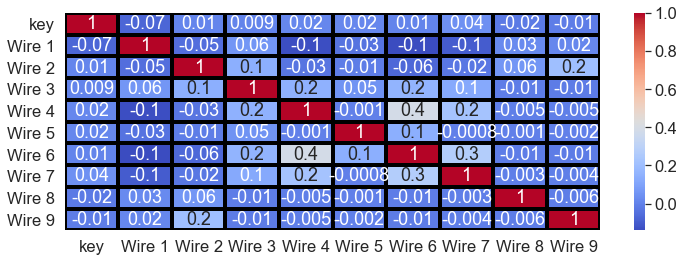

In [36]:
corr = data_wire.corr()
plt.figure(figsize= (12,4))
sns.set(font_scale=1.5) 
sns.heatmap(corr, annot=True,fmt='.1g',cmap= 'coolwarm', linewidths=3, linecolor='black')
plt.show()

Заметной корреляции между признаками нет

### Данные о проволочных материалах (время)

In [37]:
print(data_wire_time.info())
print()
print(data_wire_time.describe())
print()
data_wire_time.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB
None

               key
count  3081.000000
mean   1623.426485
std     932.996726
min       1.000000
25%     823.000000
50%    1619.000000
75%    2434.000000
max    3241.000000



,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Даная таблица аналогична для data_wire, как  data_bulk_time  для  data_bulk.

In [38]:
def fillna_zero(df):
    for i in df.columns.drop('key'):
        df[i] = df[i].fillna(0)
    return df

#применение функции
fillna_zero(data_wire_time)
data_wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,0,0,0,0,0,0,0,0
1,2,2019-05-03 11:46:10,0,0,0,0,0,0,0,0
2,3,2019-05-03 12:13:47,0,0,0,0,0,0,0,0
3,4,2019-05-03 12:48:05,0,0,0,0,0,0,0,0
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,0,0,0,0,0,0,0


##  Дополнительное задание 

 Для каждого значения столбца key найдите:

* Длительность времени между первым и последним замером температуры.
* Суммарное время нагрева электродами, то есть сумму значений по всем промежуткам между запусками нагрева электродов.
* Количество запусков нагрева электродами.
* Среднее соотношение потребления активной и реактивной мощности  

По всем полученным столбцам вычислите статистики: средние, минимальные и максимальные значения, медиану и величины 25%- и 75%-квартилей.

#### Длительность времени между первым и последним замером температуры.

In [39]:
data_more_time = ((data_temp.groupby('key')['Время замера'].agg({max,min}))).reset_index()
data_more_time.columns=['key', 'Время крайнего замера температуры','Время первого замера температуры']
data_more_time['Длительность между первым и последним замером температуры'] = data_more_time['Время крайнего замера температуры'] - data_more_time['Время первого замера температуры']
data_more_time.head()

,key,Время крайнего замера температуры,Время первого замера температуры,Длительность между первым и последним замером температуры
0,1,2019-05-03 11:30:39,2019-05-03 11:16:18,00:14:21
1,2,2019-05-03 11:59:12,2019-05-03 11:37:27,00:21:45
2,3,2019-05-03 12:34:57,2019-05-03 12:13:17,00:21:40
3,4,2019-05-03 12:59:25,2019-05-03 12:52:57,00:06:28
4,5,2019-05-03 13:36:01,2019-05-03 13:23:19,00:12:42


#### Суммарное время нагрева электродами, то есть сумму значений по всем промежуткам между запусками нагрева электродов

In [40]:
data_more_heat= (data_arc.groupby('key')['Продолжительность нагрева дугой'].sum()).reset_index()
data_more_heat.columns=['key','Суммарное время нагрева электродами']
data_more_heat.head()

,key,Суммарное время нагрева электродами
0,1,00:18:18
1,2,00:13:31
2,3,00:10:55
3,4,00:12:21
4,5,00:14:29


#### Количество запусков нагрева электродами

In [41]:
data_more_heat_count= (data_arc.groupby('key')['Продолжительность нагрева дугой'].count()).reset_index()
data_more_heat_count.columns=['key','Кол-во запусков нагрева электродами']
data_more_heat_count.head()
data_more_heat_count.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 2 columns):
 #   Column                               Non-Null Count  Dtype
---  ------                               --------------  -----
 0   key                                  3214 non-null   int64
 1   Кол-во запусков нагрева электродами  3214 non-null   int64
dtypes: int64(2)
memory usage: 50.3 KB


#### Среднее соотношение потребления активной и реактивной мощности

In [42]:
data_more_power = (data_arc.groupby('key')['Активная мощность','Реактивная мощность'].mean()).reset_index()
data_more_power.columns=['key','Среднее значение активной мощности','Серднее значение реактивной мощности']
data_more_power['Среднее отношение активной к реактивной мощности'] = data_more_power['Среднее значение активной мощности']/data_more_power['Серднее значение реактивной мощности']
data_more_power.head()

,key,Среднее значение активной мощности,Серднее значение реактивной мощности,Среднее отношение активной к реактивной мощности
0,1,0.975629,0.636648,1.532447
1,2,0.763150,0.499528,1.527741
2,3,0.505176,0.319815,1.579589
3,4,0.802313,0.515074,1.557663
4,5,0.836793,0.563161,1.485887


In [43]:
data_more_power2= (data_arc.groupby('key')['Полная мощность','Реактивная мощность','Активная мощность'].sum()).reset_index()
data_more_power2.columns=['key','Полная мощность партии','Реактивная мощность','Активная мощность']
data_more_power2.head()

,key,Полная мощность партии,Реактивная мощность,Активная мощность
0,1,5.826395,3.183241,4.878147
1,2,3.649216,1.998112,3.052598
2,3,2.989534,1.599076,2.525882
3,4,3.814962,2.060298,3.209250
4,5,4.035758,2.252643,3.347173


#### По всем полученным столбцам вычислите статистики: средние, минимальные и максимальные значения, медиану и величины 25%- и 75%-квартилей.

In [44]:
data_more_all = data_more_time.merge(data_more_heat ,on='key')
data_more_all = data_more_all.merge(data_more_heat_count ,on='key')
data_more_all = data_more_all.merge(data_more_power ,on='key')
display(data_more_all.head())
data_more_all.info()
data_more_all.describe()


,key,Время крайнего замера температуры,Время первого замера температуры,Длительность между первым и последним замером температуры,Суммарное время нагрева электродами,Кол-во запусков нагрева электродами,Среднее значение активной мощности,Серднее значение реактивной мощности,Среднее отношение активной к реактивной мощности
0,1,2019-05-03 11:30:39,2019-05-03 11:16:18,00:14:21,00:18:18,5,0.975629,0.636648,1.532447
1,2,2019-05-03 11:59:12,2019-05-03 11:37:27,00:21:45,00:13:31,4,0.763150,0.499528,1.527741
2,3,2019-05-03 12:34:57,2019-05-03 12:13:17,00:21:40,00:10:55,5,0.505176,0.319815,1.579589
3,4,2019-05-03 12:59:25,2019-05-03 12:52:57,00:06:28,00:12:21,4,0.802313,0.515074,1.557663
4,5,2019-05-03 13:36:01,2019-05-03 13:23:19,00:12:42,00:14:29,4,0.836793,0.563161,1.485887


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 9 columns):
 #   Column                                                     Non-Null Count  Dtype          
---  ------                                                     --------------  -----          
 0   key                                                        3214 non-null   int64          
 1   Время крайнего замера температуры                          3214 non-null   datetime64[ns] 
 2   Время первого замера температуры                           3214 non-null   datetime64[ns] 
 3   Длительность между первым и последним замером температуры  3214 non-null   timedelta64[ns]
 4   Суммарное время нагрева электродами                        3214 non-null   timedelta64[ns]
 5   Кол-во запусков нагрева электродами                        3214 non-null   int64          
 6   Среднее значение активной мощности                         3214 non-null   float64        
 7   Серднее значение реактивн

,key,Длительность между первым и последним замером температуры,Суммарное время нагрева электродами,Кол-во запусков нагрева электродами,Среднее значение активной мощности,Серднее значение реактивной мощности,Среднее отношение активной к реактивной мощности
count,3214.000000,3214,3214,3214.000000,3214.000000,3214.000000,3214.000000
mean,1623.061294,0 days 00:30:41.006533,0 days 00:13:14.545115,4.628189,0.671067,0.501532,1.345269
std,934.739859,0 days 00:20:46.492873,0 days 00:05:32.491076,1.608866,0.207490,0.153933,0.135673
min,1.000000,0 days 00:03:17,0 days 00:00:57,1.000000,0.186226,0.130062,0.609224
25%,817.250000,0 days 00:19:38.250000,0 days 00:09:31,4.000000,0.519691,0.387213,1.277312
50%,1623.500000,0 days 00:26:23,0 days 00:12:50,4.000000,0.646633,0.489478,1.357526
75%,2431.750000,0 days 00:37:15,0 days 00:16:23,6.000000,0.797201,0.599788,1.429244
max,3241.000000,0 days 06:32:17,0 days 01:09:49,16.000000,1.819169,1.141721,1.777119


### Формируем результирующую таблицу

In [45]:
data_final = data_temp_info.merge(data_more_all, how='left', on=['key','Время крайнего замера температуры','Время первого замера температуры'])
data_final.head()

,key,Время крайнего замера температуры,Время первого замера температуры,Температура в начале замера,Температура в конце замера,Время всего нагрева,Длительность между первым и последним замером температуры,Суммарное время нагрева электродами,Кол-во запусков нагрева электродами,Среднее значение активной мощности,Серднее значение реактивной мощности,Среднее отношение активной к реактивной мощности
0,1,2019-05-03 11:30:39,2019-05-03 11:16:18,1571.0,1613.0,00:14:21,00:14:21,00:18:18,5.0,0.975629,0.636648,1.532447
1,2,2019-05-03 11:59:12,2019-05-03 11:37:27,1577.0,1602.0,00:21:45,00:21:45,00:13:31,4.0,0.763150,0.499528,1.527741
2,3,2019-05-03 12:34:57,2019-05-03 12:13:17,1596.0,1599.0,00:21:40,00:21:40,00:10:55,5.0,0.505176,0.319815,1.579589
3,4,2019-05-03 12:59:25,2019-05-03 12:52:57,1601.0,1625.0,00:06:28,00:06:28,00:12:21,4.0,0.802313,0.515074,1.557663
4,5,2019-05-03 13:36:01,2019-05-03 13:23:19,1576.0,1602.0,00:12:42,00:12:42,00:14:29,4.0,0.836793,0.563161,1.485887


In [46]:
data_final = data_final.merge(data_bulk, on=['key'],how='left')
data_final.head()

,key,Время крайнего замера температуры,Время первого замера температуры,Температура в начале замера,Температура в конце замера,Время всего нагрева,Длительность между первым и последним замером температуры,Суммарное время нагрева электродами,Кол-во запусков нагрева электродами,Среднее значение активной мощности,Серднее значение реактивной мощности,Среднее отношение активной к реактивной мощности,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,2019-05-03 11:30:39,2019-05-03 11:16:18,1571.0,1613.0,00:14:21,00:14:21,00:18:18,5.0,0.975629,0.636648,1.532447,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,2019-05-03 11:59:12,2019-05-03 11:37:27,1577.0,1602.0,00:21:45,00:21:45,00:13:31,4.0,0.763150,0.499528,1.527741,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,2019-05-03 12:34:57,2019-05-03 12:13:17,1596.0,1599.0,00:21:40,00:21:40,00:10:55,5.0,0.505176,0.319815,1.579589,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,2019-05-03 12:59:25,2019-05-03 12:52:57,1601.0,1625.0,00:06:28,00:06:28,00:12:21,4.0,0.802313,0.515074,1.557663,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,2019-05-03 13:36:01,2019-05-03 13:23:19,1576.0,1602.0,00:12:42,00:12:42,00:14:29,4.0,0.836793,0.563161,1.485887,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


In [47]:
data_final = data_final.merge(data_wire, on=['key'],how='left')
data_final.head()

,key,Время крайнего замера температуры,Время первого замера температуры,Температура в начале замера,Температура в конце замера,Время всего нагрева,Длительность между первым и последним замером температуры,Суммарное время нагрева электродами,Кол-во запусков нагрева электродами,Среднее значение активной мощности,Серднее значение реактивной мощности,Среднее отношение активной к реактивной мощности,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:30:39,2019-05-03 11:16:18,1571.0,1613.0,00:14:21,00:14:21,00:18:18,5.0,0.975629,0.636648,1.532447,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,2019-05-03 11:59:12,2019-05-03 11:37:27,1577.0,1602.0,00:21:45,00:21:45,00:13:31,4.0,0.763150,0.499528,1.527741,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,2019-05-03 12:34:57,2019-05-03 12:13:17,1596.0,1599.0,00:21:40,00:21:40,00:10:55,5.0,0.505176,0.319815,1.579589,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,2019-05-03 12:59:25,2019-05-03 12:52:57,1601.0,1625.0,00:06:28,00:06:28,00:12:21,4.0,0.802313,0.515074,1.557663,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,2019-05-03 13:36:01,2019-05-03 13:23:19,1576.0,1602.0,00:12:42,00:12:42,00:14:29,4.0,0.836793,0.563161,1.485887,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
data_final = data_final.merge(data_gas, on=['key'],how='left')
data_final.head()

,key,Время крайнего замера температуры,Время первого замера температуры,Температура в начале замера,Температура в конце замера,Время всего нагрева,Длительность между первым и последним замером температуры,Суммарное время нагрева электродами,Кол-во запусков нагрева электродами,Среднее значение активной мощности,Серднее значение реактивной мощности,Среднее отношение активной к реактивной мощности,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,Газ 1
0,1,2019-05-03 11:30:39,2019-05-03 11:16:18,1571.0,1613.0,00:14:21,00:14:21,00:18:18,5.0,0.975629,0.636648,1.532447,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.749986
1,2,2019-05-03 11:59:12,2019-05-03 11:37:27,1577.0,1602.0,00:21:45,00:21:45,00:13:31,4.0,0.763150,0.499528,1.527741,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.555561
2,3,2019-05-03 12:34:57,2019-05-03 12:13:17,1596.0,1599.0,00:21:40,00:21:40,00:10:55,5.0,0.505176,0.319815,1.579589,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.554793
3,4,2019-05-03 12:59:25,2019-05-03 12:52:57,1601.0,1625.0,00:06:28,00:06:28,00:12:21,4.0,0.802313,0.515074,1.557663,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.841219
4,5,2019-05-03 13:36:01,2019-05-03 13:23:19,1576.0,1602.0,00:12:42,00:12:42,00:14:29,4.0,0.836793,0.563161,1.485887,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.413692


Выведем информацию о рез-ей таблице

In [49]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2477 entries, 0 to 2476
Data columns (total 37 columns):
 #   Column                                                     Non-Null Count  Dtype          
---  ------                                                     --------------  -----          
 0   key                                                        2477 non-null   int64          
 1   Время крайнего замера температуры                          2477 non-null   datetime64[ns] 
 2   Время первого замера температуры                           2477 non-null   datetime64[ns] 
 3   Температура в начале замера                                2477 non-null   float64        
 4   Температура в конце замера                                 2477 non-null   float64        
 5   Время всего нагрева                                        2477 non-null   timedelta64[ns]
 6   Длительность между первым и последним замером температуры  2475 non-null   timedelta64[ns]
 7   Суммарное время нагрева 

Удалим пропуски

In [50]:
data_final = data_final.dropna()
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2476
Data columns (total 37 columns):
 #   Column                                                     Non-Null Count  Dtype          
---  ------                                                     --------------  -----          
 0   key                                                        2329 non-null   int64          
 1   Время крайнего замера температуры                          2329 non-null   datetime64[ns] 
 2   Время первого замера температуры                           2329 non-null   datetime64[ns] 
 3   Температура в начале замера                                2329 non-null   float64        
 4   Температура в конце замера                                 2329 non-null   float64        
 5   Время всего нагрева                                        2329 non-null   timedelta64[ns]
 6   Длительность между первым и последним замером температуры  2329 non-null   timedelta64[ns]
 7   Суммарное время нагрева 

Признаки **"Длительность между первым и последним замером температуры"** и **"Суммарное время нагрева электродам"** переведем в формат float64 для удобства

In [51]:
data_final['Длительность между первым и последним замером температуры в сек']=data_final[:]['Длительность между первым и последним замером температуры'] / np.timedelta64(1, 's')
data_final['Суммарное время нагрева электродами в сек']=data_final[:]['Суммарное время нагрева электродами'] / np.timedelta64(1, 's')

Теперь можно удалить лишние столбцы:  
* Время крайнего замера температуры
* Время первого замера температуры
* Длительность между первым и последним замером температуры
* Суммарное время нагрева электродами
* Время всего нагрева 
* Key

In [52]:
data_final = data_final.drop(columns=['Время крайнего замера температуры','Время первого замера температуры','Длительность между первым и последним замером температуры','Суммарное время нагрева электродами','key','Время всего нагрева'])
data_final.head()

,Температура в начале замера,Температура в конце замера,Кол-во запусков нагрева электродами,Среднее значение активной мощности,Серднее значение реактивной мощности,Среднее отношение активной к реактивной мощности,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,Газ 1,Длительность между первым и последним замером температуры в сек,Суммарное время нагрева электродами в сек
0,1571.0,1613.0,5.0,0.975629,0.636648,1.532447,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.749986,861.0,1098.0
1,1577.0,1602.0,4.0,0.763150,0.499528,1.527741,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.555561,1305.0,811.0
2,1596.0,1599.0,5.0,0.505176,0.319815,1.579589,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.554793,1300.0,655.0
3,1601.0,1625.0,4.0,0.802313,0.515074,1.557663,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.841219,388.0,741.0
4,1576.0,1602.0,4.0,0.836793,0.563161,1.485887,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.413692,762.0,869.0


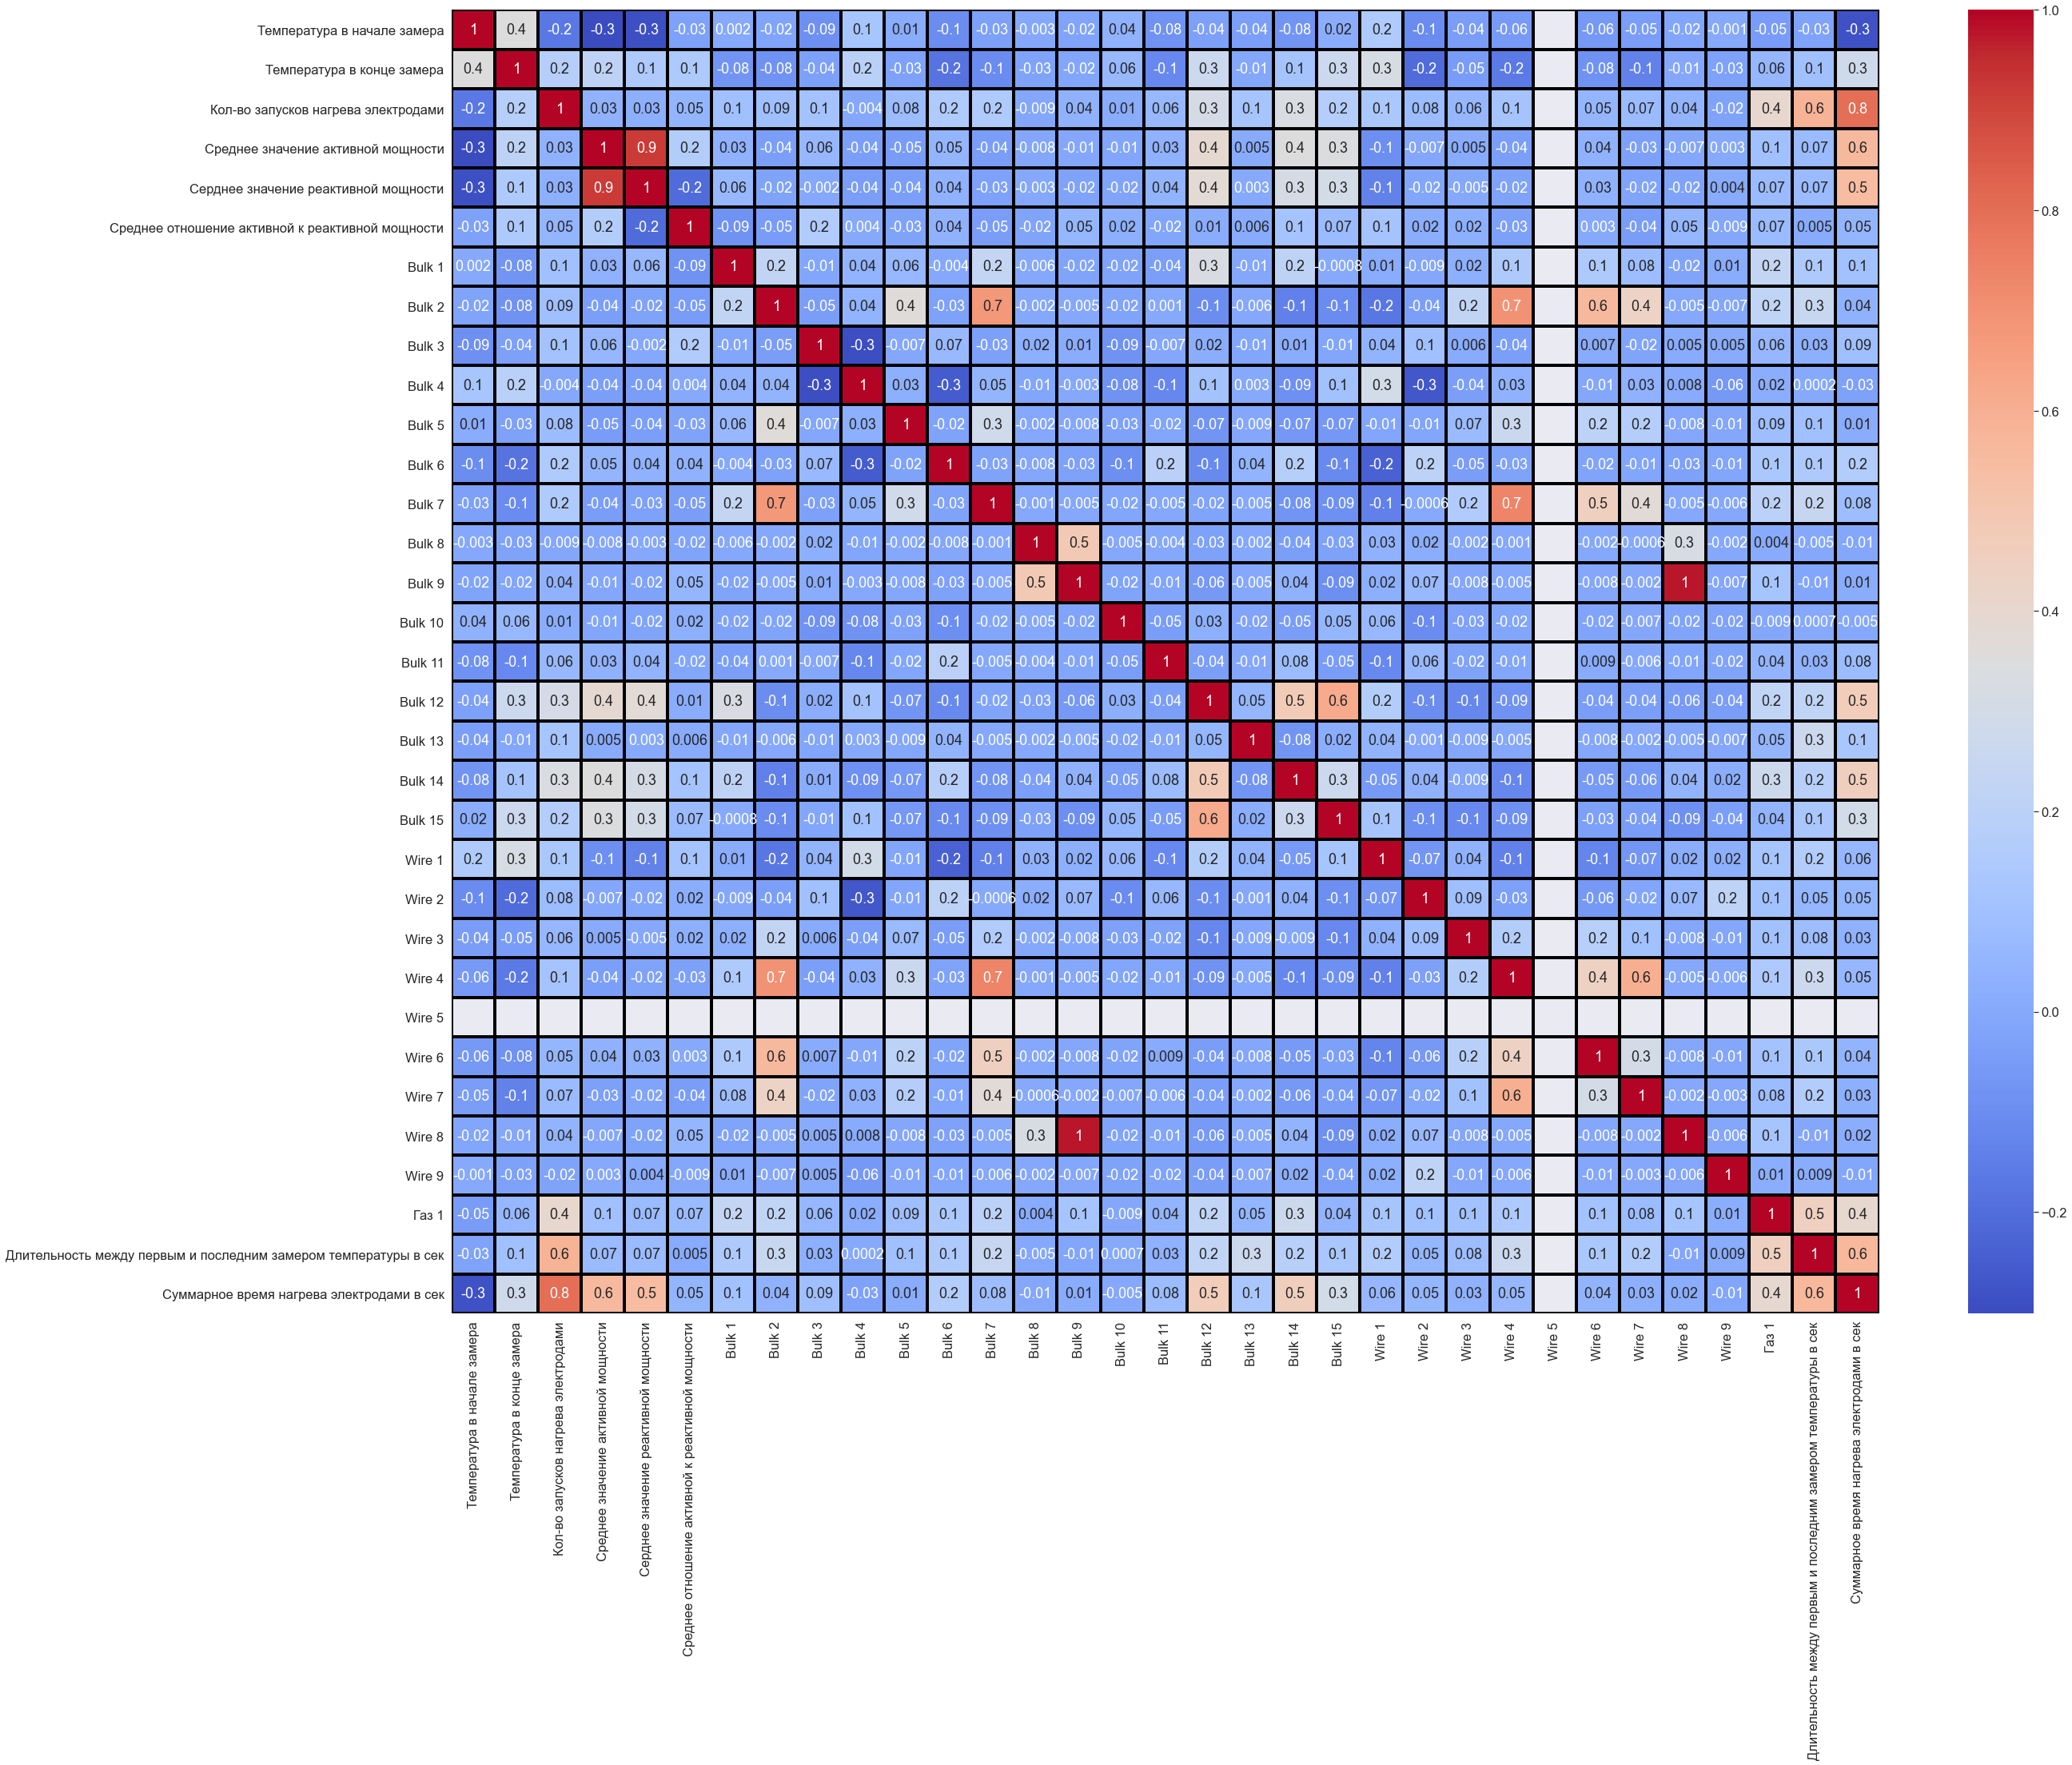

In [53]:
corr = data_final.corr()
plt.figure(figsize= (40,30))
sns.set(font_scale=1.5) 
sns.heatmap(corr, annot=True,fmt='.1g',cmap= 'coolwarm', linewidths=3, linecolor='black')
plt.show()

После обучения первой модели и полечения **features_importance**, кол-во незначительных признаков скоратим, так же сократим сильно коррелирующие признаки.

## Обучение модели LGBMRegressor

Выделим целовой и остальные признаки:

In [54]:
features  = data_final.drop(columns='Температура в конце замера',axis=1)
target = data_final['Температура в конце замера']

Разбиваем данные на обучающий и тестовый набор

In [55]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=12345,shuffle=True)

print("Размер обучающего набора: {}\nРазмер тестового набора:"
         " {}\n".format(X_train.shape[0], X_test.shape[0]))

Размер обучающего набора: 1746
Размер тестового набора: 583



In [56]:
%%time
            
model_lgbm = LGBMRegressor()
params = {'learning_rate': [i for i in np.geomspace(0.01,1.0,6)],
          'n_estimators':[i for i in range(100, 1000, 100)],
          'max_depth':[i for i in range(1, 5, 1)],
          'random_state':[12345]}
grid_lgbm = GridSearchCV(model_lgbm, params, cv=5)
grid_lgbm.fit(X_train, y_train)

best_params_lgbm = grid_lgbm.best_params_
print('best parameters', best_params_lgbm)

best parameters {'learning_rate': 0.06309573444801933, 'max_depth': 4, 'n_estimators': 500, 'random_state': 12345}
Wall time: 4min 22s


In [57]:
model = LGBMRegressor()
model.set_params(**best_params_lgbm)
model.fit(X_train, y_train)
target_predict = model.predict(X_test)
test_mae_lgbm = mean_absolute_error(target_predict, y_test)
print('MAE на LGBMRegressor =', test_mae_lgbm)

MAE на LGBMRegressor = 4.147759130989029


##  Важности признаков 

In [58]:
features_import = model.feature_importances_
df_features_import = pd.Series(features_import, index=X_train.columns).sort_values(ascending=False)
print(df_features_import)

Температура в начале замера                                        587
Суммарное время нагрева электродами в сек                          437
Длительность между первым и последним замером температуры в сек    377
Bulk 14                                                            351
Газ 1                                                              350
Среднее значение активной мощности                                 326
Wire 1                                                             311
Серднее значение реактивной мощности                               272
Среднее отношение активной к реактивной мощности                   258
Bulk 12                                                            257
Кол-во запусков нагрева электродами                                194
Bulk 15                                                            164
Bulk 3                                                             159
Wire 2                                                             132
Bulk 6

Оставим только наиболее важые признаки

In [59]:
data_final_2 = data_final.copy()
data_final_2 = data_final_2.loc[:,['Температура в начале замера','Суммарное время нагрева электродами в сек','Длительность между первым и последним замером температуры в сек','Bulk 14','Газ 1','Среднее значение активной мощности','Wire 1','Серднее значение реактивной мощности','Среднее отношение активной к реактивной мощности','Bulk 12','Кол-во запусков нагрева электродами','Bulk 15','Bulk 3','Wire 2','Bulk 6' ]]

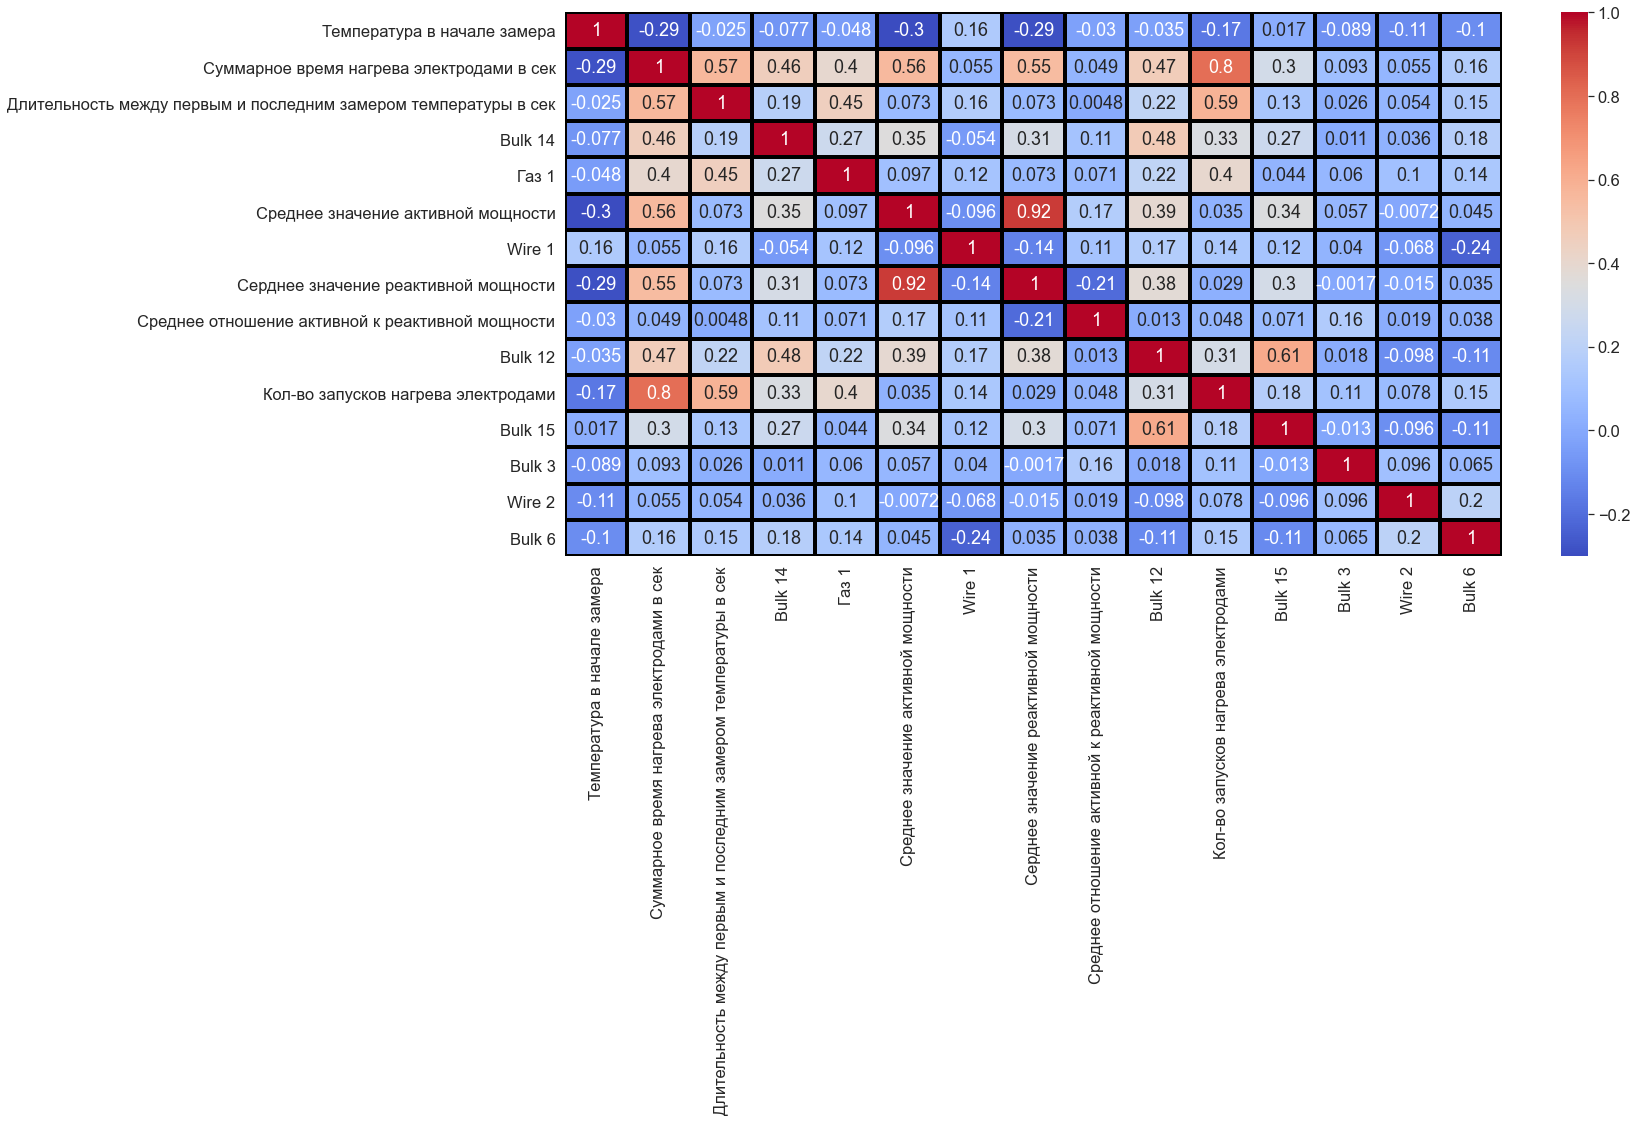

In [60]:
corr = data_final_2.corr()
plt.figure(figsize= (21,10)) 
sns.heatmap(corr, annot=True,fmt='.2g',cmap= 'coolwarm', linewidths=3, linecolor='black')
plt.show()

Удалим **'Серднее значение реактивной мощности'**и **'Кол-во запусков нагрева электродами'** в связи с высокой корреляцией с другими признаками

In [61]:
data_final_2 = data_final_2.drop(columns=['Серднее значение реактивной мощности','Кол-во запусков нагрева электродами'])

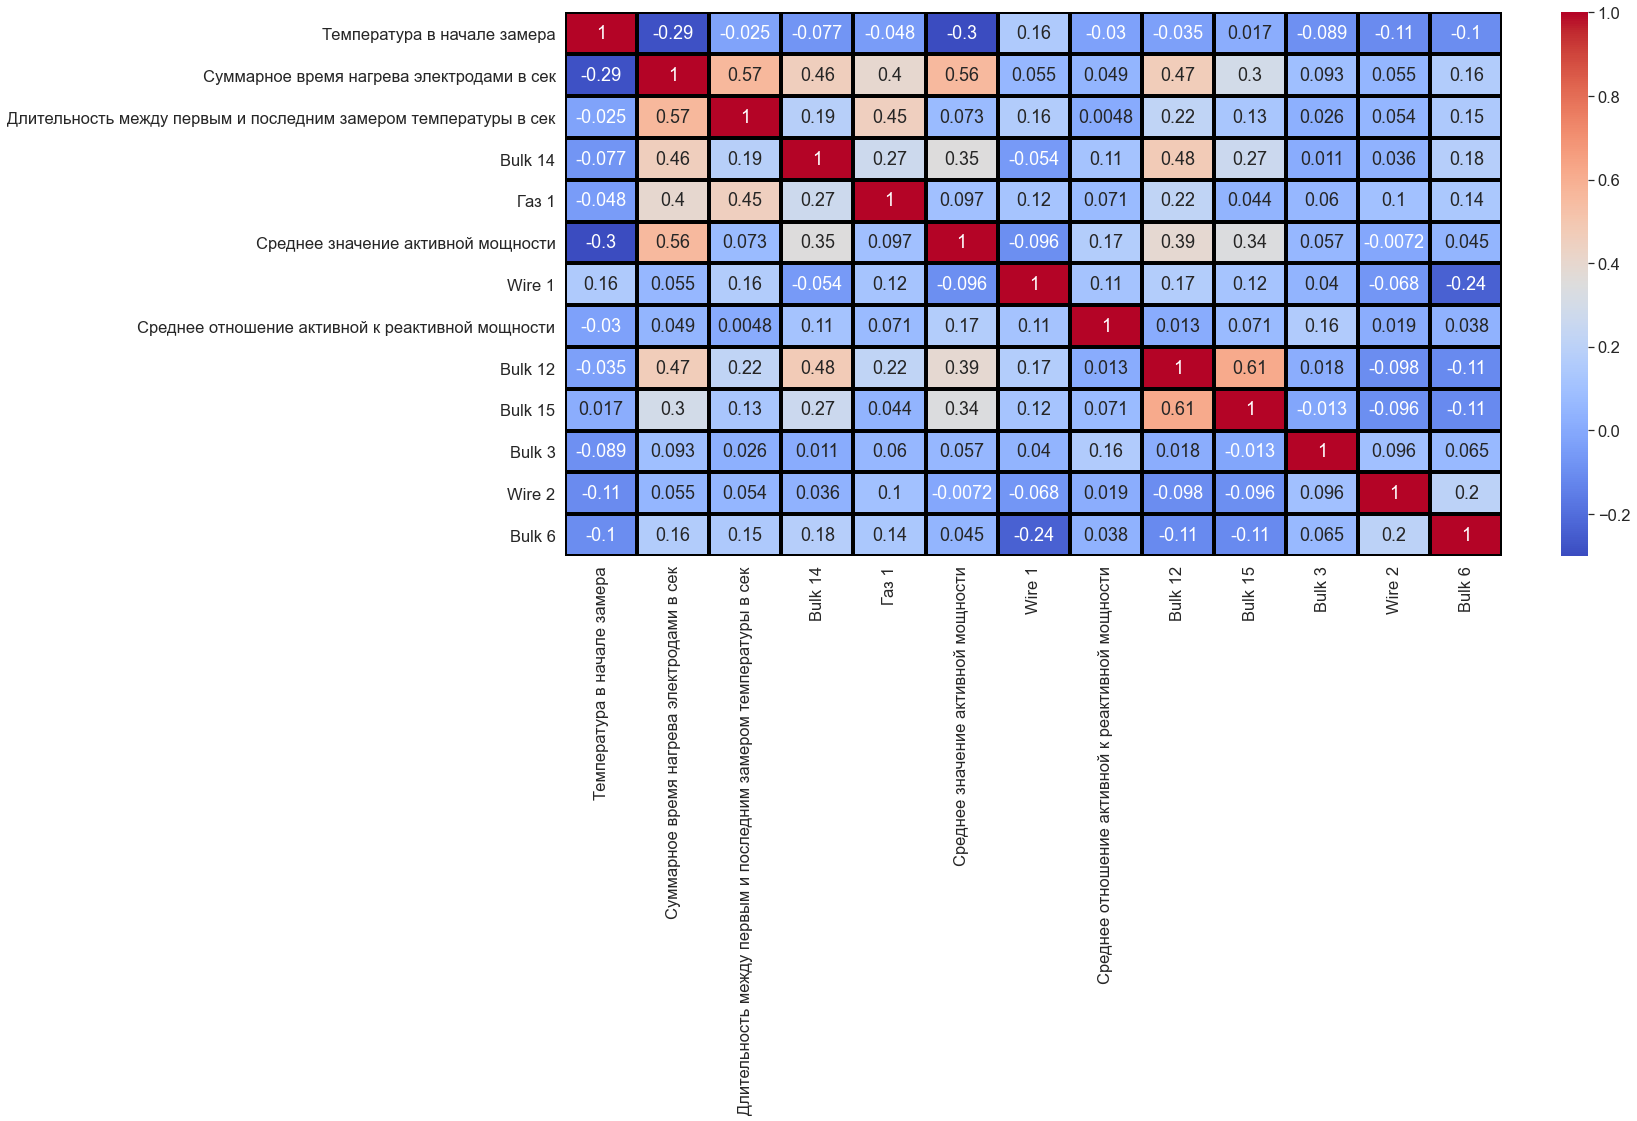

In [62]:
corr = data_final_2.corr()
plt.figure(figsize= (21,10)) 
sns.heatmap(corr, annot=True,fmt='.2g',cmap= 'coolwarm', linewidths=3, linecolor='black')
plt.show()

In [63]:
features2  = data_final_2
target2 = data_final['Температура в конце замера']

In [64]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(features2, target2, test_size=0.25, random_state=12345,shuffle=True)

print("Размер обучающего набора: {}\nРазмер тестового набора:"
         " {}\n".format(X_train2.shape[0], X_test2.shape[0]))

Размер обучающего набора: 1746
Размер тестового набора: 583



In [65]:
%%time
            
model_lgbm = LGBMRegressor()
params = {'learning_rate': [i for i in np.geomspace(0.01,1.0,6)],
          'n_estimators':[i for i in range(100, 1000, 100)],
          'max_depth':[i for i in range(1, 5, 1)],
          'random_state':[12345]}
grid_lgbm = GridSearchCV(model_lgbm, params, cv=5)
grid_lgbm.fit(X_train2, y_train2)

best_params_lgbm = grid_lgbm.best_params_
print('best parameters', best_params_lgbm)

best parameters {'learning_rate': 0.025118864315095794, 'max_depth': 4, 'n_estimators': 800, 'random_state': 12345}
Wall time: 5min 6s


In [66]:
model = LGBMRegressor()
model.set_params(**best_params_lgbm)
model.fit(X_train2, y_train2)
target_predict = model.predict(X_test2)
test_mae_lgbm = mean_absolute_error(target_predict, y_test2)
print('MAE', test_mae_lgbm.round(1))

MAE 4.2


## Сравнение итоговой относительно константной модели

In [67]:
model_const= DummyRegressor()
model_const.fit(X_train2, y_train2)
model_const_predict = model_const.predict(X_test2)
test_mae_const = mean_absolute_error(model_const_predict, y_test2)
print('MAE:',test_mae_const.round(1))

MAE: 8.4


## Вывод 

Мы выполнили  легкую подготовку данных: удалили 1 выброс, выполнили замену пропусков. Из предложенных наборов данных, составили результирующую таблицу. На модели МО LGBMRegressor мы достигли требуемого значения MAE<=6.00, мы получили МАЕ=4,2